#### IMPORTS


In [171]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

### PART 1 - IMAGE CARTOONIFY

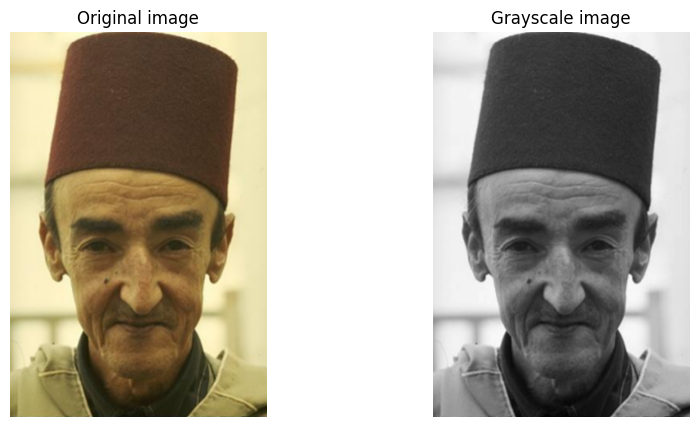

In [172]:
imgPath="man.png"
img=cv.imread(imgPath)
gray_img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
img=cv.cvtColor(img, cv.COLOR_BGR2RGB)
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Original image')
plt.imshow(img, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Grayscale image')
plt.imshow(gray_img, cmap='gray')
plt.axis('off')

plt.show()


### APPLYING MEDIAN FILTER

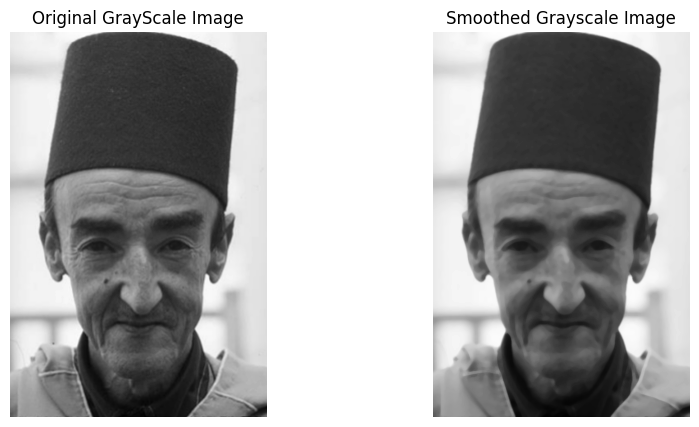

In [173]:
 # Apply median filter (non linear filter) handles noise
filtered_img = cv.medianBlur(gray_img,9)  
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Original GrayScale Image')
plt.imshow(gray_img, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Smoothed Grayscale Image')
plt.imshow(filtered_img, cmap='gray')
plt.axis('off')

plt.show()


### APPLYING LAPLACIAN FOR EDGE DETECTION

(-0.5, 531.5, 798.5, -0.5)

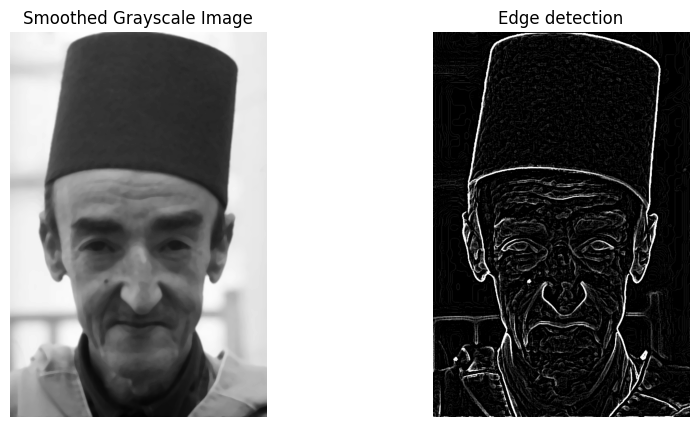

In [174]:
#linear filter
laplacian_img = cv.Laplacian(filtered_img, cv.CV_8U,ksize=5)#pixels values from 0 to 255, and cannot take negative values.
# laplacian_img = np.uint8(np.absolute(laplacian_img))
# laplacian_img = cv.convertScaleAbs(laplacian_img)
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Smoothed Grayscale Image')
plt.imshow(filtered_img, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Edge detection')
plt.imshow(laplacian_img, cmap='gray')
plt.axis('off')

### APPLYING THRESHOLDING

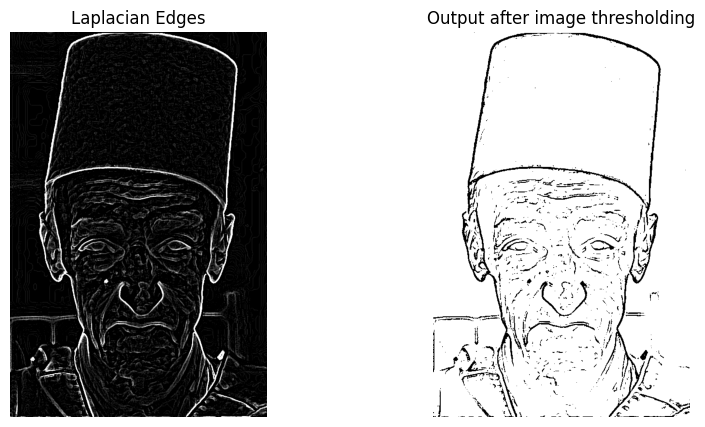

In [175]:
_, thresholding = cv.threshold(laplacian_img,70, 255, cv.THRESH_BINARY_INV)
# Display the results
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Laplacian Edges')
plt.imshow(laplacian_img, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Output after image thresholding')
plt.imshow(thresholding, cmap='gray')
plt.axis('off')

plt.show()

### APPLYING BILATERAL FILTER

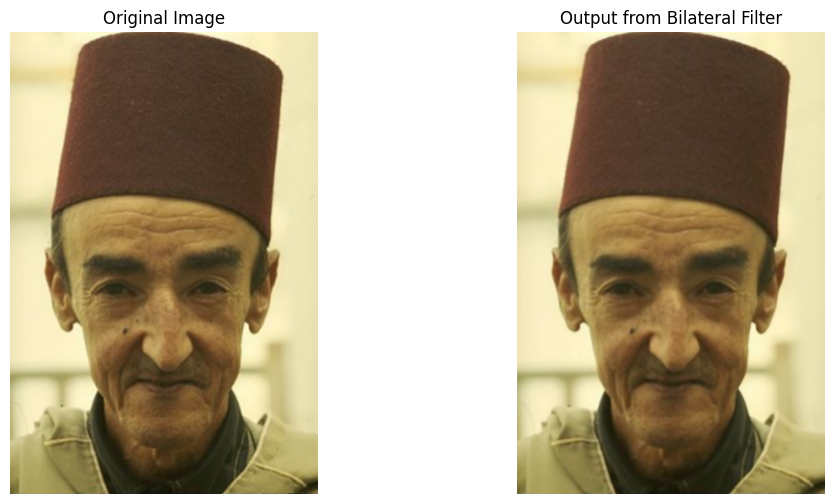

In [176]:

#Larger values of sigma Color mean that pixels with similar colors will be closer to each other
#A higher value of sigma space means that pixels farther away from the central pixel will be included in the averaging process
filtered_image = cv.bilateralFilter(img, d=5,sigmaColor=80,sigmaSpace=80)#kernel shape depends on the image content
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(img)
plt.axis('off')
plt.subplot(1, 2, 2)
plt.title('Output from Bilateral Filter')
plt.imshow(filtered_image)
plt.axis('off')

plt.show()

### CARTOON IMAGE

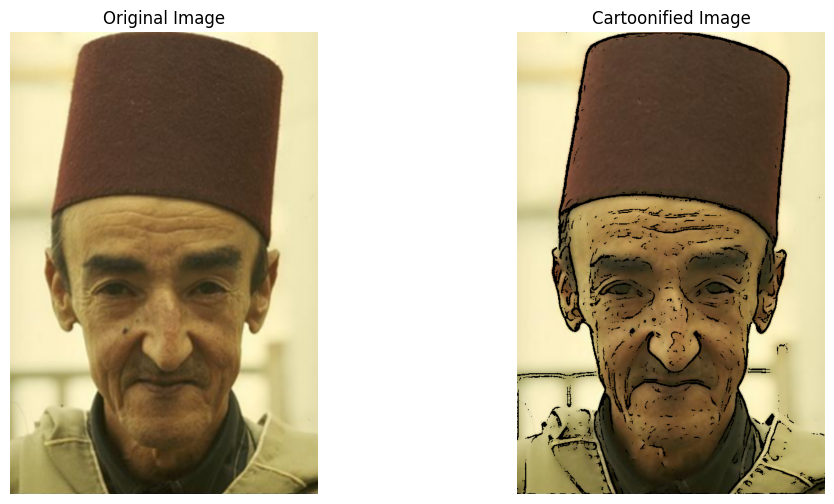

In [177]:
#replacing areas of edges with black
filtered_image[thresholding == 0] = 0
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(img)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Cartoonified Image')
plt.imshow(filtered_image)
plt.axis('off')

plt.show()

#### READING IMAGE


In [178]:

def show_image(image , string):
    plt.figure(figsize=(10, 5))
    plt.imshow(image, cmap='gray')
    plt.title(string)
    plt.axis("off")
    plt.show()
    

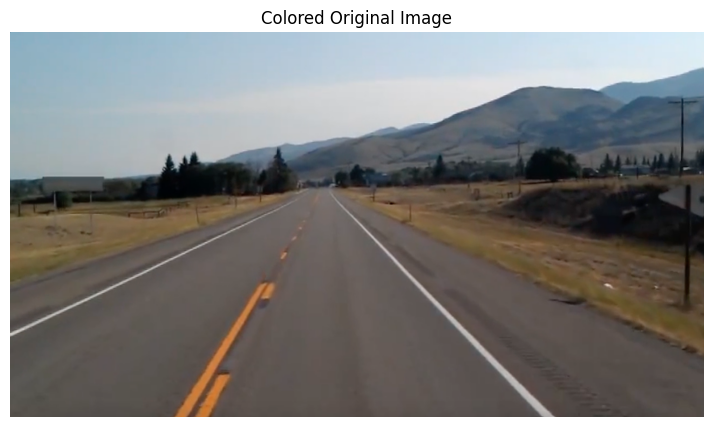

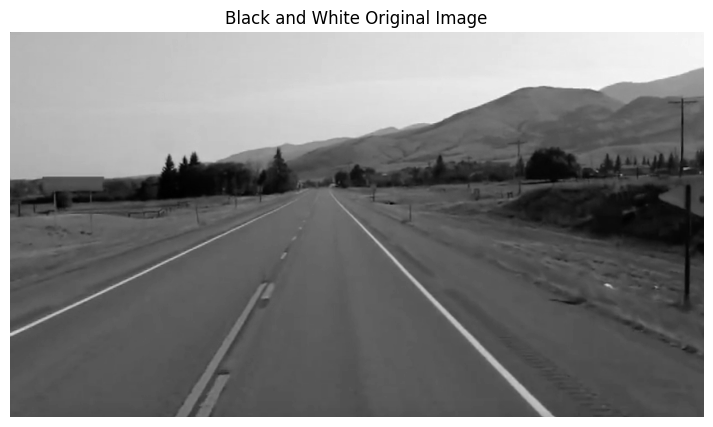

In [ ]:

color_img = cv.imread('road.png')
color_img = cv.cvtColor(color_img , cv.COLOR_BGR2RGB)
img = cv.cvtColor(color_img, cv.COLOR_BGR2GRAY)
# gray bec --> edge detection and hough use 1 channel images 
# Bec we only need intensity gradient not color


show_image(color_img , "Colored Original Image")
show_image(img , "Black and White Original Image")
if img is None:
    print("Image not found!!!!!")



#### IMPLEMENTATION DETAILS
##### 1) Smoothing the image

In [193]:
def smoothing (img):
    # 2D median smoothing filter to reduce noise and remove false edges
    # median blur filter --> removes Salt and Pepper Noise
    # kernel --> 5 to not smooth too much or too little
    return cv.medianBlur(img , 9)


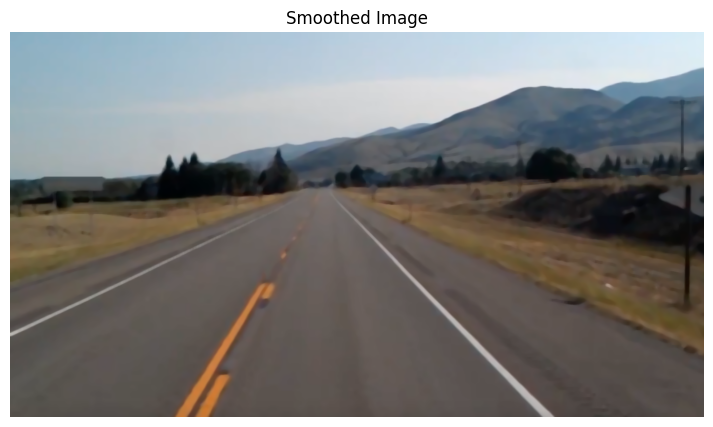

In [195]:
smoothed_image = smoothing(color_img)
show_image(smoothed_image, "Smoothed Image")

##### 2) Edge Detection

In [219]:
def edges_detection (img):
    # Canny detection with high threshold for high noise reduction
    # Canny finds areas with large intensity gradients --> edges

    # Computes gradient magnitude (using Sobel or similar filters)
    
    # Thresholds to control edges sensitivity :
    # 200 --> detect weaker edges
    # 100 --> strong edge detection
    return cv.Canny(img ,200 , 100)

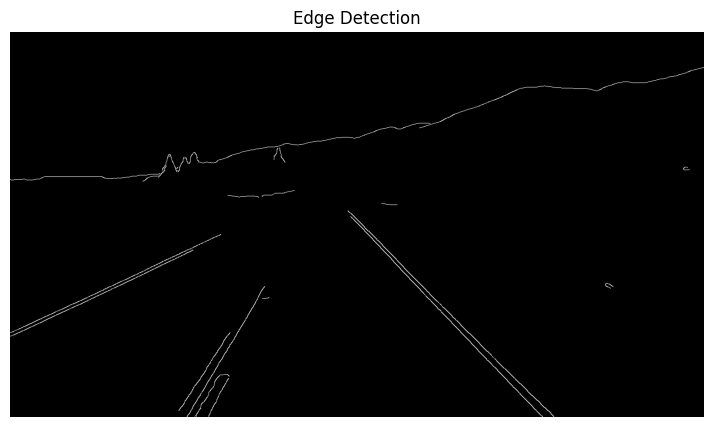

In [220]:
edges = edges_detection(smoothed_image)
show_image(edges, "Edge Detection")

##### 3) Region of Intreset

In [198]:
# ROI helps focus only on road 

def region_of_interest(img):
    #  polyone mask to isolate lane lines and eliminate noise
    h, w = img.shape

    #  defines vertices of ROI 
    polygon = np.array([[
        (0, h),
        (w, h),
        (w, int(h*0.5)),
        (0, int(h*0.5))
    ]], np.int32)
    
    mask = np.zeros_like(img)
    #  make the polygon filled white
    cv.fillPoly(mask, polygon, 255)
    masked_image = cv.bitwise_and(img, mask)
    # bitwise and to apply roi mask to edge detected image
    # keeps edges within the polygon only
    return masked_image  


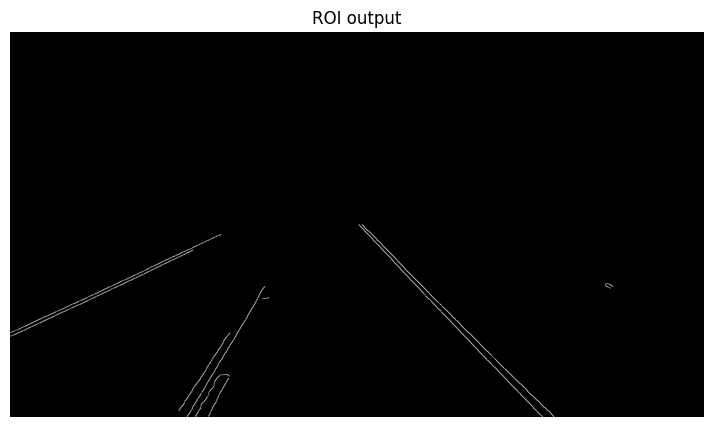

In [199]:
cropped_edges = region_of_interest(edges)
show_image(cropped_edges , "ROI output")

##### 4) Accumulator Plot 

In [200]:
#  hough identifies lines in edge detected image 
#  for each edge point it calculates votes of possible lines that could pass through it
def hough_transform(img):
    h, w = img.shape
    # maximum distance rho (p) in hough space
    max_dist = int(np.sqrt(h**2 + w**2))
    # theta from 0 to 180 degrees in radians
    theta_range = np.deg2rad(np.arange(0, 180))  

    p_range = np.arange(-max_dist, max_dist)
    
    # initialize accumulator array with zeros
    accumulator = np.zeros((len(p_range), len(theta_range)), dtype=np.int32)
    # coordinates of edge points (x,y)
    edge_points = np.argwhere(img) 
    
    # Hough Transform
    for y, x in edge_points:
        for i, theta in enumerate(theta_range):
            #  rho (p) --> the distance from orgin to line (top left)
            p = int(x * np.cos(theta) + y * np.sin(theta))
            # p --> positive
            p_index = p + max_dist  
            # accumulate votes
            accumulator[p_index, i] += 1
    
    return accumulator , theta_range, p_range


In [201]:

def plot_accumulator(accumulator):
    # visualize the accumulator array
    plt.imshow(accumulator, cmap='hot', aspect='auto')
    plt.xlabel('Theta in radian')
    plt.ylabel('p in rho pixels')
    plt.title('Hough Accumulator Array')
    plt.colorbar()
    plt.show()

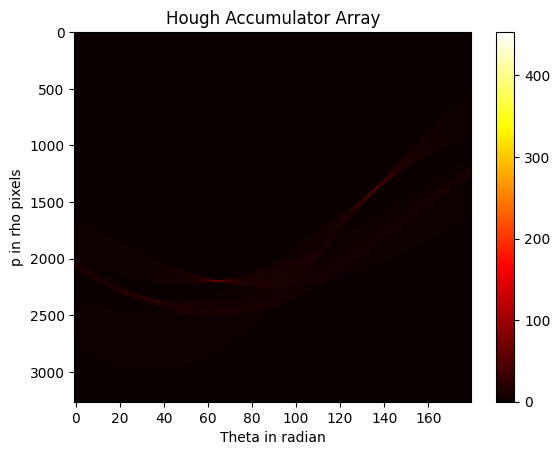

In [ ]:
accumulator, theta_range, p_range = hough_transform(cropped_edges)
plot_accumulator(accumulator)

# points in image space --> curves(sin waves) in the Hough space
# intersections of these curves --> presence of lines
# bright spots --> strong evidence of line 
# intensity --> strength/confidence in detection


##### 5) Refining Coordinates

In [235]:
# identifies strongest lines based on threshold
#  threshold value filtes out lines with fewer votes


def refine_lines(accumulator, rho_range, theta_range, threshold=200):
   
    refined_lines = []

    for rho_idx in range(accumulator.shape[0]):
        for theta_idx in range(accumulator.shape[1]):
            # if the vote count in the accumulator >= the threshold
            if accumulator[rho_idx, theta_idx] >= threshold:
                # index --> rho and theta values
                rho = rho_range[rho_idx]
                theta = theta_range[theta_idx]


                # filter lines by angle --> to only keep near-vertical lines
                # angle = np.rad2deg(theta)
                # if 20 < angle < 160:
                #     continue
                # angle = np.rad2deg(theta)
                # if angle < 30 or angle > 150: 
                #     refined_lines.append((rho, theta))
                refined_lines.append((rho, theta))
    print(f"Number of refined lines: {len(refined_lines)}")
    return refined_lines


#### Final Picture With Detected Lanes

In [236]:
def calculate_intersection(x1, y1, x2, y2, y):
    # intersection of point on line with y axis
    
    # slope --> add small value to avoid division by 0
    m = (y2 - y1) / (x2 - x1 + 1e-6)  
    
    x = int(x1 + (y - y1) / m)  
    return x, y

In [237]:

def draw_lines(img, lines):
    # empty image to draw lines on
    line_img = np.zeros_like(img)  
    
    # ROI region
    height, _ = img.shape[:2]
    p_height_fraction=0.5  # to define the top boundary of ROI
    p_top_y = int(height * p_height_fraction)  

    
    for p, theta in lines:
        # polar coordinates (p, theta) --> cartesian coordinates (x1, y1) & (x2, y2)
        a = np.cos(theta)
        b = np.sin(theta) 
        x0 = a * p
        y0 = b * p
        #  trig equations
        x1 = int(x0 + 2000 * (-b))
        y1 = int(y0 + 2000 * a)
        x2 = int(x0 - 2000 * (-b))
        y2 = int(y0 - 2000 * a)

        # endpoints --> fit within ROI
        if y1 < p_top_y:
            x1, y1 = calculate_intersection(x1, y1, x2, y2, y=p_top_y)
        if y2 < p_top_y:
            x2, y2 = calculate_intersection(x1, y1, x2, y2, y=p_top_y)
        cv.line(line_img, (x1, y1), (x2, y2), (0, 255, 0), 2)

    # overlay the line image on original image
    final_img = cv.addWeighted(img, 0.8, line_img, 1, 0)

    plt.figure(figsize=(10, 5))
    plt.imshow(final_img)
    plt.title("Original Image with Detected Lanes")
    plt.axis("off")
    plt.show()


Number of refined lines: 6


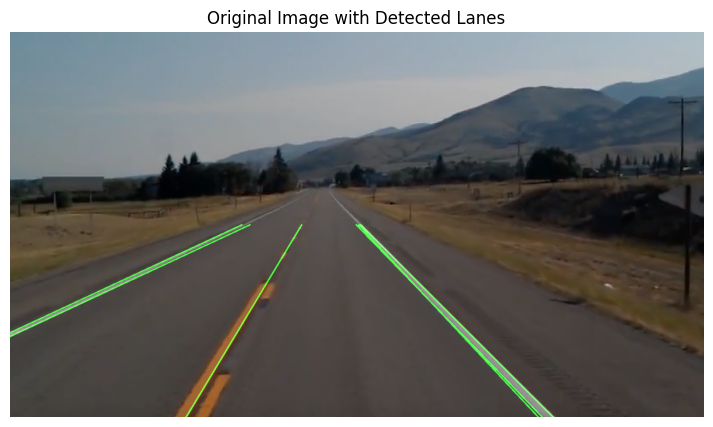

In [238]:
refined_lines = refine_lines(accumulator, p_range, theta_range)
draw_lines(color_img, refined_lines)